#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Integration

Here, we consider the problem of numerically evaluating definite integrals
$$\int_a^b f(x) dx $$
and will mostly consider finite domains $-\infty < a < b < \infty$.
As with interpolation, we will be able to create very accurate and efficient methods for certain classes of functions while other functions will be more challenging.
For each integration technique we try, we're going to need to test its accuracy.
Let's create some test functions and their derivatives.

<IPython.core.display.Javascript object>


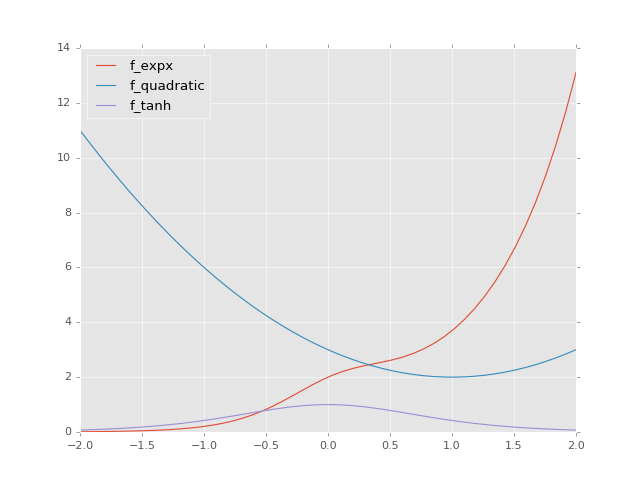

In [20]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

tests = []

@tests.append
class f_expx:
    def F(x):
        return numpy.exp(2*x)/(1+x**2)
    def f(x):
        return 2*numpy.exp(2*x)/(1+x**2) - numpy.exp(2*x)/(1+x**2)**2 * 2*x

@tests.append
class f_quadratic:
    def F(x):
        return x**3/3 - x**2 + 3*x - 1
    def f(x):
        return x**2 - 2*x + 3
    
@tests.append
class f_tanh:
    def F(x):
        return numpy.tanh(x)
    def f(x):
        return numpy.cosh(x)**(-2)

pyplot.style.use('ggplot')
pyplot.rcParams['figure.max_open_warning'] = False
pyplot.figure()
x = numpy.linspace(-2,2)
for t in tests:
    pyplot.plot(x, t.f(x), label=t.__name__)
pyplot.legend(loc='upper left')

## Fundamental Theorem of Calculus

Let $f(x)$ be a continuous function and define $F(x)$ by
$$ F(x) = \int_a^x f(s) ds . $$
Then $F(x)$ is uniformly continuous, differentiable, and
$$ F'(x) = f(x) . $$
We say that $F$ is an antiderivative of $f$.
This implies that
$$ \int_a^b f(x) dx = F(b) - F(a) . $$
We will test the accuracy of our integration schemes using an antiderivative provided in our tests.

### Method of Manufactured Solutions

Analytically integrating an arbitrary function is hard, tends to require trickery, and is not always possible to express in closed form (e.g., [elliptic integrals](https://en.wikipedia.org/wiki/Elliptic_integral)).  In contrast, analytic differentiation involves straightforward application of the product rule and chain rule.  So if we just choose an arbitrary function $F$ (the antiderivative), we can compute $f = F'$, then numerically integrate $\int_a^b f$ and compare to $F(b) - F(a)$.  We have used this technique to produce the `tests` array above.

## Newton-Cotes methods

Newton-Cotes methods approximate $f(x)$ using piecewise polynomial functions.  Polynomials are easy to integrate analytically so we need only sum up the integrals over each piecewise interval.

### Midpoint rule

The midpoint method uses piecewise constant functions over some number $n$ of intervals.

In [26]:
def fint_midpoint(f, a, b, n=20):
    dx = (b - a)/n     # Width of each interval
    x = numpy.linspace(a+dx/2, b-dx/2, n)
    return numpy.sum(f(x))*dx

for t in tests:
    a, b = -2, 2
    I = fint_midpoint(t.f, a, b, 50)
    print('{:12s}: I={: 10e} error={: 10e}'.format(t.__name__, I, I - (t.F(b) - t.F(a))))

f_expx      : I= 1.091108e+01 error=-4.882008e-03
f_quadratic : I= 1.733120e+01 error=-2.133333e-03
f_tanh      : I= 1.928128e+00 error= 7.260722e-05


<IPython.core.display.Javascript object>


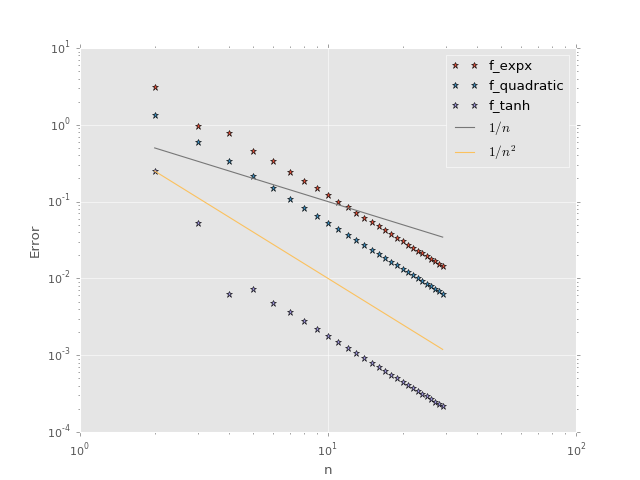

In [43]:
# How fast does this method converge?

def plot_accuracy(fint, tests, ns):
    a, b = -2, 2
    ns = numpy.array(ns)
    pyplot.figure()
    for t in tests:
        Is = numpy.array([fint(t.f, a, b, n) for n in ns])
        Errors = numpy.abs(Is - (t.F(b) - t.F(a)))
        pyplot.loglog(ns, Errors, '*', label=t.__name__)
    pyplot.loglog(ns, 1/ns, label='$1/n$')
    pyplot.loglog(ns, 1/ns**2, label='$1/n^2$')
    pyplot.ylabel('Error')
    pyplot.xlabel('n')
    pyplot.legend(loc='upper right')
    
plot_accuracy(fint_midpoint, tests, range(2,30))

### Measuring accuracy

A common situation with numerical integration is that the function $f(x)$ has a significant cost relative to the additions and multiplications needed to scale and sum the values.  The cost per integration point is constant for most methods that we will consider, therefore the number of function evaluations $n$ is a good measure of the cost.  Some algorithms may have higher cost per quadrature point in which case we will need to trade off the superlinear cost of quadrature with the linear cost of evaluating the function.

### Trapezoid Rule

The trapezoid rule uses piecewise linear functions on each interval.

$$\begin{split} \int_a^b f(a) + \frac{f(b) - f(a)}{b - a} (x - a) &= f(a) (x-a) + \frac{f(b) - f(a)}{2(b - a)} (x - a)^2 \Big|_{x=a}^b \\
&= f(a) (b-a) + \frac{f(b) - f(a)}{2(b - a)} (b-a)^2 \\
&= \frac{b-a}{2} \big( f(a) + f(b) \big) .
\end{split} $$

* Can you get to the same result using a geometric argument?
* What happens when we sum over a bunch of adjacent intervals?

<IPython.core.display.Javascript object>


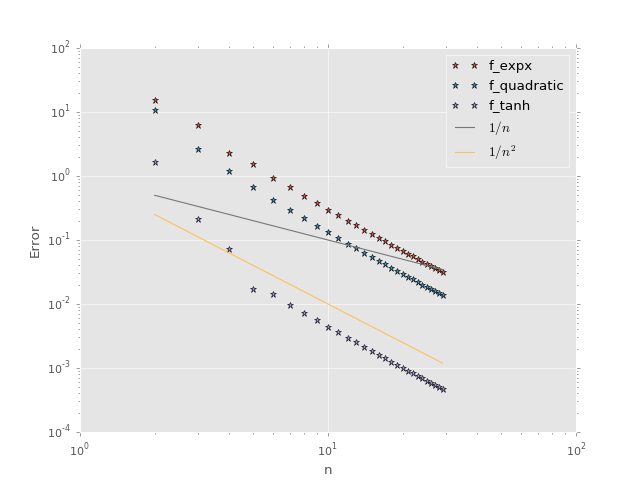

In [47]:
def fint_trapezoid(f, a, b, n=20):
    dx = (b - a) / (n - 1)     # We evaluate endpoints of n-1 intervals
    x = numpy.linspace(a, b, n)
    fx = f(x)
    fx[[0,-1]] *= .5
    return numpy.sum(fx)*dx

plot_accuracy(fint_trapezoid, tests, range(2,30))

In [50]:
for t in tests:
    a, b = -2, 2
    for n in [10, 20, 40, 80, 160, 320]:
        I = fint_midpoint(t.f, a, b, n)
        print('{:12s}: n={: 4d} I={: 10e} error={: 10e}'.format(t.__name__, n, I, I - (t.F(b) - t.F(a))))

f_expx      : n=  10 I= 1.079515e+01 error=-1.208209e-01
f_expx      : n=  20 I= 1.088552e+01 error=-3.044403e-02
f_expx      : n=  40 I= 1.090834e+01 error=-7.626298e-03
f_expx      : n=  80 I= 1.091406e+01 error=-1.907533e-03
f_expx      : n= 160 I= 1.091549e+01 error=-4.769431e-04
f_expx      : n= 320 I= 1.091585e+01 error=-1.192395e-04
f_quadratic : n=  10 I= 1.728000e+01 error=-5.333333e-02
f_quadratic : n=  20 I= 1.732000e+01 error=-1.333333e-02
f_quadratic : n=  40 I= 1.733000e+01 error=-3.333333e-03
f_quadratic : n=  80 I= 1.733250e+01 error=-8.333333e-04
f_quadratic : n= 160 I= 1.733313e+01 error=-2.083333e-04
f_quadratic : n= 320 I= 1.733328e+01 error=-5.208333e-05
f_tanh      : n=  10 I= 1.929845e+00 error= 1.789576e-03
f_tanh      : n=  20 I= 1.928508e+00 error= 4.523930e-04
f_tanh      : n=  40 I= 1.928169e+00 error= 1.134112e-04
f_tanh      : n=  80 I= 1.928084e+00 error= 2.837237e-05
f_tanh      : n= 160 I= 1.928062e+00 error= 7.094316e-06
f_tanh      : n= 320 I= 1.92805